# Predictions

In this notebook we'll learn how to predict the prices of short term rental listings using a linear regression model.

In [1]:
%matplotlib notebook

from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

pd.set_option('display.max_colwidth', -1)

In [2]:
graph = Graph("bolt://localhost", auth=("neo4j", "neo"))

For this section we need to install the [ml-models](https://github.com/neo4j-graph-analytics/ml-models) procedures library. You can find installation instructions on the [releases pages](https://github.com/neo4j-graph-analytics/ml-models/releases/tag/1.0.1). 

Once you've done that, run the following code to check that the library is installed:

In [38]:
query = """
CALL dbms.procedures() 
YIELD name WHERE name STARTS WITH 'regression' 
RETURN *
"""

graph.run(query).to_data_frame()

,name
0,regression.linear.add
1,regression.linear.addM
2,regression.linear.clear
3,regression.linear.copy
4,regression.linear.create
5,regression.linear.delete
6,regression.linear.info
7,regression.linear.load
8,regression.linear.remove
9,regression.linear.removeM


We're going to predict the prices for listings within one New York neighborhood. We want to pick a neighborhood that has a good number of listings so let's first write a query to find a good neighborhood to use:

In [39]:
query = """
MATCH (nh:Neighborhood)<-[:IN_NEIGHBORHOOD]-()
RETURN nh.name AS nh, count(*) AS listings
ORDER BY listings DESC
LIMIT 10
"""

graph.run(query).to_data_frame()

,listings,nh
0,5431,Williamsburg
1,3639,Bedford-Stuyvesant
2,2873,Harlem
3,2476,Bushwick
4,2219,Upper West Side
5,2176,Hell's Kitchen
6,2079,Alphabet City
7,2035,Upper East Side
8,1671,Crown Heights
9,1653,Midtown


Before we do any predictions let's get an overview of the prices in Williamsburg. We can create a scatterplot to help us do this:

In [15]:
# amazing scatterplot

query = """
MATCH (nh:Neighborhood {name: $name})<-[:IN_NEIGHBORHOOD]-(listing)
RETURN listing.price AS price
"""

place = "Williamsburg"
df = graph.run(query, {"name": place}).to_data_frame()
df["price"].describe()

count    5415.000000
mean     133.801477 
std      92.103999  
min      0.000000   
25%      70.000000  
50%      104.000000 
75%      170.000000 
max      950.000000 
Name: price, dtype: float64

<IPython.core.display.Javascript object>


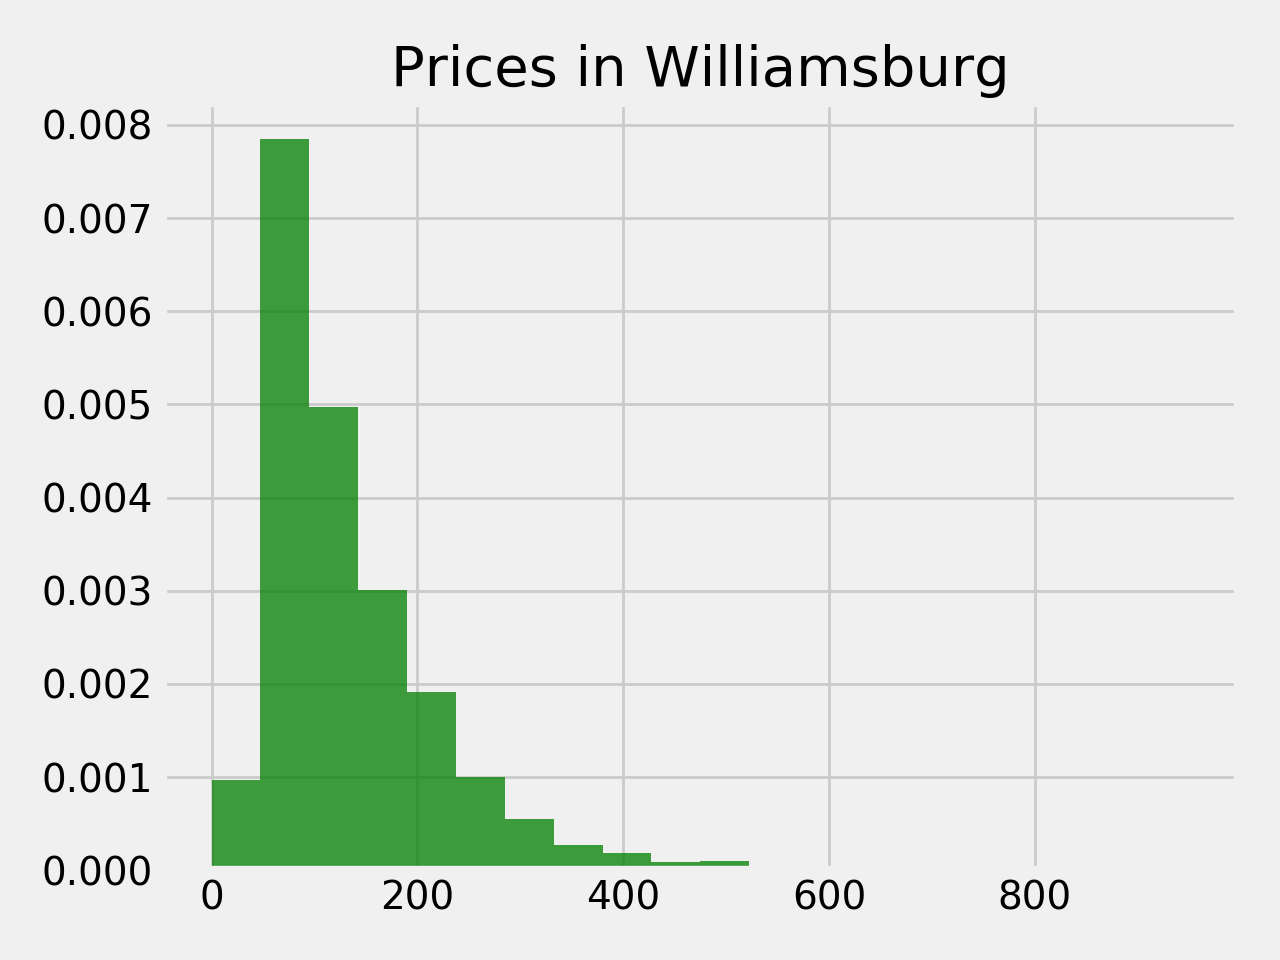

In [41]:
plt.hist(df["price"].dropna(), 20, density=True, facecolor='g', alpha=0.75)
plt.title(f"Prices in {place}")
plt.tight_layout()

This looks like a classic long tail distribution - the massive majority of listings are prices below $200 and then there are a few outliers at much higher price brackets.

Let's split training and test data:

In [82]:
split_data_train_query = """
MATCH (list:Listing)-[:IN_NEIGHBORHOOD]->(:Neighborhood {name: $name}) 
WHERE exists(list.bedrooms) AND exists(list.bathrooms)
AND exists(list.price) 
AND (:Review)-[:REVIEWS]->(list) 
WITH regression.linear.split(collect(id(list)), 0.75) AS trainingIDs
MATCH (list:Listing) WHERE id(list) in trainingIDs 
SET list:Train
"""

split_data_test_query = """
MATCH (list:Listing)-[n:IN_NEIGHBORHOOD]->(:Neighborhood {name: $name})
WHERE exists(list.bedrooms) AND exists(list.bathrooms)
AND exists(list.price) 
AND (:Review)-[:REVIEWS]->(list) 
AND NOT list:Train 
SET list:Test
"""

graph.run(split_data_train_query, {"name": place}).summary().counters
graph.run(split_data_test_query, {"name": place}).summary().counters

{'labels_added': 1063}

In [3]:
correlation_query = """
MATCH (list) 
WHERE list:Test OR list:Train
WITH collect(size((list)<-[:REVIEWS]-()) * 1.0) AS reviews,
     collect(list.bedrooms + list.bathrooms) as rooms
RETURN regression.linear.correlation(reviews, rooms)
"""

graph.run(correlation_query).to_data_frame()

,"regression.linear.correlation(reviews, rooms)"
0,0.03091


In [133]:
model_name = "rental-prices-gc2"

In [109]:
init_query = """
CALL regression.linear.create($modelName, 'Multiple', true, 3)
"""

graph.run(init_query, {"modelName": model_name}).summary().counters

{}

In [115]:
add_training_data_query = """
MATCH (list:Train)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  [list.bedrooms, list.bathrooms, size((list)<-[:REVIEWS]-()) * 1.0], 
  list.price
) 
SET list:Seen 
RETURN count(list)
"""

graph.run(add_training_data_query, {"modelName": model_name}).summary().counters

{'labels_added': 3187}

In [116]:
train_model_query = """
CALL regression.linear.train($modelName)
"""

graph.run(train_model_query, {"modelName": model_name}).to_data_frame()

,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-gc2,0,3187,3,testing,{},"{'RSquared': 0.3039820459974215, 'SSR': 8356593.563522778, 'SSE': 19133824.61595636, 'SST': 27490418.179479137, 'adjRSquared': 0.30332604415576014, 'parameters std error': [4.347473462881658, 2.123898458080135, 3.813783455624787, 0.035897576738769664], 'parameters': [19.159202976461337, 62.983262122535564, 37.13360700591205, 0.018367754527362622], 'MSE': 6011.2549845920075}"


In [117]:
add_test_data_query = """
MATCH (list:Test) 
WHERE NOT list:Seen
CALL regression.linear.add($modelName, 
  [list.bedrooms, list.bathrooms, size((list)<-[:REVIEWS]-()) * 1.0],  
  list.price, 
  'test'
) 
SET list:Seen 
RETURN count(list)
"""

graph.run(add_test_data_query, {"modelName": model_name}).data()

[{'count(list)': 1063}]

In [118]:
test_model_query = """
CALL regression.linear.test($modelName)
"""

graph.run(test_model_query, {"modelName": model_name}).to_data_frame()

,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-gc2,1063,3187,3,ready,"{'adjRSquared': 0.2298271918146202, 'RSquared': 0.23127761141572245, 'SSE': 6496856.635075453, 'SST': 8451499.177798672, 'MSE': 6129.11003309005}","{'RSquared': 0.3039820459974215, 'SSR': 8356593.563522778, 'SSE': 19133824.61595636, 'SST': 27490418.179479137, 'adjRSquared': 0.30332604415576014, 'parameters std error': [4.347473462881658, 2.123898458080135, 3.813783455624787, 0.035897576738769664], 'parameters': [19.159202976461337, 62.983262122535564, 37.13360700591205, 0.018367754527362622], 'MSE': 6011.2549845920075}"


In [134]:
info_query = """
CALL regression.linear.info($modelName) 
"""

graph.run(info_query, {"modelName": model_name}).to_data_frame()

,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-gc2,1063,3187,3,ready,"{'adjRSquared': 0.2298271918146202, 'RSquared': 0.23127761141572245, 'SSE': 6496856.635075453, 'SST': 8451499.177798672, 'MSE': 6129.11003309005}","{'RSquared': 0.3039820459974215, 'SSR': 8356593.563522778, 'SSE': 19133824.61595636, 'SST': 27490418.179479137, 'adjRSquared': 0.30332604415576014, 'parameters std error': [4.347473462881658, 2.123898458080135, 3.813783455624787, 0.035897576738769664], 'parameters': [19.159202976461337, 62.983262122535564, 37.13360700591205, 0.018367754527362622], 'MSE': 6011.2549845920075}"


Let's add some more features to our model. So far we've only added numerical properties - what if we want to add a categorical variable such as `propertyType`?

To work with these types of variables we'll need to create a [one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) of property types.

We can use the `algo.ml.oneHotEncoding` function to help us out. 

In [9]:
model_name = "rental-prices-propertyType"

property_type_count_query = """
match (l:Listing)
WITH l.propertyType AS propertyType, count(*) AS count
RETURN count(*) AS count
"""

property_type_count =  graph.run(property_type_count_query).to_table()[0][0]


init_query = """
CALL regression.linear.create($modelName, 'Multiple', true, $numberOfVariables)
"""

result = graph.run(init_query, {"modelName": model_name, "numberOfVariables": 3 + property_type_count})
display(result.summary().counters)

clear_seen_query = """
MATCH (s:Seen)
REMOVE s:Seen
"""

display(graph.run(clear_seen_query).summary().counters)

add_training_data_query = """
match (l:Listing)
WITH l.propertyType AS propertyType, count(*) AS count
WITH collect(propertyType) AS propertyTypes

MATCH (list:Train)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, list.bathrooms, size((list)<-[:REVIEWS]-()) * 1.0],
    algo.ml.oneHotEncoding(propertyTypes, [list.propertyType])
  ]), 
  list.price
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_training_data_query, {"modelName": model_name}).summary().counters)

train_model_query = """
CALL regression.linear.train($modelName)
"""

display(graph.run(train_model_query, {"modelName": model_name}).to_data_frame())

add_test_data_query = """
match (l:Listing)
WITH l.propertyType AS propertyType, count(*) AS count
WITH collect(propertyType) AS propertyTypes

MATCH (list:Test)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, list.bathrooms, size((list)<-[:REVIEWS]-()) * 1.0],
    algo.ml.oneHotEncoding(propertyTypes, [list.propertyType])
  ]), 
  list.price, "test"
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_test_data_query, {"modelName": model_name}).to_data_frame())

test_model_query = """
CALL regression.linear.test($modelName)
"""

display(graph.run(test_model_query, {"modelName": model_name}).to_data_frame())

{}

{'labels_removed': 4250}

{'labels_added': 3187}

,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-9999,0,3187,36,testing,{},"{'RSquared': 0.3198966228505573, 'SSR': 8794091.936364941, 'SSE': 18696326.243114196, 'SST': 27490418.179479137, 'adjRSquared': 0.3121240128259922, 'parameters std error': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, inf], 'parameters': [2153046068740896.2, 62.981689453125, 34.16827392578125, 0.00394439697265625, -2153046068740793.0, -0.0, -2153046068740838.0, -0.0, -0.0, -2153046068740815.5, -0.0, -2153046068740867.8, -0.0, -0.0, -0.0, -0.0, -2153046068740873.5, -0.0, -0.0, -2153046068740863.5, -0.0, -2153046068740849.2, -0.0, -2153046068740898.8, -0.0, -2153046068740935.8, -0.0, -0.0, -0.0, -0.0, -2153046068740877.8, -0.0, -2153046068740887.0, -0.0, -2153046068740852.5, -2153046068740905.2, 0.0], 'MSE': 5935.341664480697}"


,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-9999,1063,3187,36,ready,"{'adjRSquared': -1.1343758191032131e+24, 'RSquared': -1.0969905519952918e+24, 'SSE': 9.27121474824112e+30, 'SST': 8451499.177798672, 'MSE': 9.027472977839454e+27}","{'RSquared': 0.3198966228505573, 'SSR': 8794091.936364941, 'SSE': 18696326.243114196, 'SST': 27490418.179479137, 'adjRSquared': 0.3121240128259922, 'parameters std error': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, inf], 'parameters': [2153046068740896.2, 62.981689453125, 34.16827392578125, 0.00394439697265625, -2153046068740793.0, -0.0, -2153046068740838.0, -0.0, -0.0, -2153046068740815.5, -0.0, -2153046068740867.8, -0.0, -0.0, -0.0, -0.0, -2153046068740873.5, -0.0, -0.0, -2153046068740863.5, -0.0, -2153046068740849.2, -0.0, -2153046068740898.8, -0.0, -2153046068740935.8, -0.0, -0.0, -0.0, -0.0, -2153046068740877.8, -0.0, -2153046068740887.0, -0.0, -2153046068740852.5, -2153046068740905.2, 0.0], 'MSE': 5935.341664480697}"


We can do the same thing with roomType:

In [11]:
model_name = "rental-prices-roomType"

count_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
RETURN count(*) AS count
"""

count =  graph.run(count_query).to_table()[0][0]


init_query = """
CALL regression.linear.create($modelName, 'Multiple', true, $numberOfVariables)
"""

result = graph.run(init_query, {"modelName": model_name, "numberOfVariables": 3 + count})
display(result.summary().counters)

clear_seen_query = """
MATCH (s:Seen)
REMOVE s:Seen
"""

display(graph.run(clear_seen_query).summary().counters)

add_training_data_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
WITH collect(roomType) AS roomTypes

MATCH (list:Train)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, list.bathrooms, size((list)<-[:REVIEWS]-()) * 1.0],
    algo.ml.oneHotEncoding(roomTypes, [list.roomType])
  ]), 
  list.price
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_training_data_query, {"modelName": model_name}).summary().counters)

train_model_query = """
CALL regression.linear.train($modelName)
"""

display(graph.run(train_model_query, {"modelName": model_name}).to_data_frame())

add_test_data_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
WITH collect(roomType) AS roomTypes

MATCH (list:Test)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, list.bathrooms, size((list)<-[:REVIEWS]-()) * 1.0],
    algo.ml.oneHotEncoding(roomTypes, [list.roomType])
  ]), 
  list.price, "test"
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_test_data_query, {"modelName": model_name}).to_data_frame())

test_model_query = """
CALL regression.linear.test($modelName)
"""

display(graph.run(test_model_query, {"modelName": model_name}).to_data_frame())

{}

{'labels_removed': 4250}

{'labels_added': 3187}

,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-propertyType3,0,3187,6,testing,{},"{'RSquared': 0.5277715902580866, 'SSR': 14508661.719443517, 'SSE': 12981756.46003562, 'SST': 27490418.179479137, 'adjRSquared': 0.5268805932585735, 'parameters std error': [801979715176552.9, 1.8187891566291614, 3.150007507886889, 0.02965955671915785, 801979715176549.9, 801979715176554.0, 801979715176553.6], 'parameters': [-248303125222395.44, 45.81201171875, 42.009521484375, 0.026076316833496094, 248303125222381.44, 248303125222473.5, 248303125222382.44], 'MSE': 4082.313352212459}"


,count(list)
0,1063


,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-propertyType3,1063,3187,6,ready,"{'adjRSquared': 0.4975001148846997, 'RSquared': 0.4998659335528508, 'SSE': 4226882.6513671875, 'SST': 8451499.177798672, 'MSE': 3998.942905740007}","{'RSquared': 0.5277715902580866, 'SSR': 14508661.719443517, 'SSE': 12981756.46003562, 'SST': 27490418.179479137, 'adjRSquared': 0.5268805932585735, 'parameters std error': [801979715176552.9, 1.8187891566291614, 3.150007507886889, 0.02965955671915785, 801979715176549.9, 801979715176554.0, 801979715176553.6], 'parameters': [-248303125222395.44, 45.81201171875, 42.009521484375, 0.026076316833496094, 248303125222381.44, 248303125222473.5, 248303125222382.44], 'MSE': 4082.313352212459}"


Another feature that we could use is whether the host is a super host. Super hosts get benefits which give them greater visibility on Airbnb:

In [12]:
model_name = "rental-prices-roomType-superHost"

count_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
RETURN count(*) AS count
"""

count =  graph.run(count_query).to_table()[0][0]


init_query = """
CALL regression.linear.create($modelName, 'Multiple', true, $numberOfVariables)
"""

result = graph.run(init_query, {"modelName": model_name, "numberOfVariables": 4 + count})
display(result.summary().counters)

clear_seen_query = """
MATCH (s:Seen)
REMOVE s:Seen
"""

display(graph.run(clear_seen_query).summary().counters)

add_training_data_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
WITH collect(roomType) AS roomTypes

MATCH (list:Train)<-[:HOSTS]-(host)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, 
     list.bathrooms, 
     size((list)<-[:REVIEWS]-()) * 1.0,
     CASE WHEN host.superhost THEN 1.0 ELSE 0.0 END
    ],
    algo.ml.oneHotEncoding(roomTypes, [list.roomType])
  ]), 
  list.price
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_training_data_query, {"modelName": model_name}).summary().counters)

train_model_query = """
CALL regression.linear.train($modelName)
"""

display(graph.run(train_model_query, {"modelName": model_name}).to_data_frame())

add_test_data_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
WITH collect(roomType) AS roomTypes

MATCH (list:Test)<-[:HOSTS]-(host)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, 
     list.bathrooms, 
     size((list)<-[:REVIEWS]-()) * 1.0,
     CASE WHEN host.superhost THEN 1.0 ELSE 0.0 END
    ],
    algo.ml.oneHotEncoding(roomTypes, [list.roomType])
  ]), 
  list.price, "test"
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_test_data_query, {"modelName": model_name}).to_data_frame())

test_model_query = """
CALL regression.linear.test($modelName)
"""

display(graph.run(test_model_query, {"modelName": model_name}).to_data_frame())

{}

{'labels_removed': 4250}

{'labels_added': 3187}

,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-roomType-superHost,0,3187,7,testing,{},"{'RSquared': 0.5277715902580866, 'SSR': 14508661.719443517, 'SSE': 12981756.46003562, 'SST': 27490418.179479137, 'adjRSquared': 0.5267317667701364, 'parameters std error': [nan, nan, nan, nan, inf, 802105842363800.9, 802105842363805.0, 802105842363804.6], 'parameters': [-248303125222395.44, 45.81201171875, 42.009521484375, 0.026076316833496094, -0.0, 248303125222381.44, 248303125222473.5, 248303125222382.44], 'MSE': 4083.5975023704373}"


,count(list)
0,1063


,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-roomType-superHost,1063,3187,7,ready,"{'adjRSquared': 0.49702426272076483, 'RSquared': 0.4998659335528508, 'SSE': 4226882.6513671875, 'SST': 8451499.177798672, 'MSE': 4002.729783491655}","{'RSquared': 0.5277715902580866, 'SSR': 14508661.719443517, 'SSE': 12981756.46003562, 'SST': 27490418.179479137, 'adjRSquared': 0.5267317667701364, 'parameters std error': [nan, nan, nan, nan, inf, 802105842363800.9, 802105842363805.0, 802105842363804.6], 'parameters': [-248303125222395.44, 45.81201171875, 42.009521484375, 0.026076316833496094, -0.0, 248303125222381.44, 248303125222473.5, 248303125222382.44], 'MSE': 4083.5975023704373}"


# Clustering Amenities

Listings have amenities, and presumably those amenities have some impact on the price of the listing. The following query shows the average price of listings that have different amenities:

In [19]:
amenity_query = """
MATCH (a:Amenity)<-[:HAS]-(listing)-[:IN_NEIGHBORHOOD]-(:Neighborhood {name: $name})
RETURN a.name, count(*) AS count, avg(listing.price	) AS averagePrice
ORDER BY averagePrice DESC
LIMIT 20
"""

graph.run(amenity_query, {"name": place}).to_data_frame()

,a.name,averagePrice,count
0,Disabled parking spot,280.666667,6
1,Mobile hoist,275.000000,1
2,EV charger,258.333333,3
3,Stair gates,252.444444,18
4,Changing table,251.777778,18
5,Bathtub with bath chair,250.000000,1
6,Crib,244.088889,45
7,Fireplace guards,244.000000,4
8,Babysitter recommendations,243.357143,56
9,Children’s books and toys,242.443396,106


There are lots of baby/child related amenities in these high priced listings, but if we wanted to find if a listing has any of them we'd have to create a manual list of them which isn't much fun. Perhaps we can cluster amenities so that the child friendly ones get grouped together?

We can use the Jaccard Similarity algorithm to help us do this. The following query will create an 'amenity similarity graph' - each amenity gets up to 3 'SIMILAR_AMENITY' relationships to other amenities based on their cooccurence in listings.

In [21]:
similar_amenities = """
MATCH (a:Amenity)<-[:HAS]-(listing)
WITH {item:id(a), categories: collect(id(listing))} as userData
WITH collect(userData) as data
CALL algo.similarity.jaccard(data, {topK:3, similarityCutoff:0.1, writeRelationshipType: "SIMILAR_AMENITY", write: true})
YIELD nodes, similarityPairs, write, writeRelationshipType, writeProperty, min, max, mean, stdDev, p25, p50, p75, p90, p95, p99, p999, p100
RETURN nodes, similarityPairs, write, writeRelationshipType, writeProperty, min, max, mean, p95
"""

graph.run(similar_amenities).to_data_frame()

,max,mean,min,nodes,p95,similarityPairs,write,writeProperty,writeRelationshipType
0,1.000007,0.399742,0.103417,127,0.877861,280,True,score,SIMILAR_AMENITY


We can then run the Label Propagation clustering algorithm over this similarity graph to cluster the amenities.

In [24]:
amenity_clusters = """
call algo.labelPropagation.stream("Amenity", "SIMILAR_AMENITY", {iterations: 10})
YIELD nodeId, label
WITH label, collect(algo.getNodeById(nodeId).name) AS amenities
WHERE size(amenities) > 1
RETURN label, amenities
ORDER BY size(amenities) DESC
"""

graph.run(amenity_clusters).to_data_frame()

,amenities,label
0,"[Wifi, Kitchen, Cable TV, Carbon monoxide detector, Essentials, Buzzer/wireless intercom, Family/kid friendly, Laptop friendly workspace, Lock on bedroom door, Hair dryer, Hot water, Washer, Elevator, Host greets you, Keypad, translation missing: en.hosting_amenity_50, 24-hour check-in, First aid kit, Paid parking off premises, Pets allowed, Private entrance, Pool, TV, Internet, Air conditioning, Shampoo, Hangers, Iron, Free street parking, Heating, Smoke detector, Fire extinguisher, Wheelchair accessible, Suitable for events, Breakfast, Safety card, Dryer, Self check-in, translation missing: en.hosting_amenity_49, Doorman, Other, Lockbox, Gym, Building staff, Smoking allowed]",5
1,"[Oven, Dishes and silverware, Coffee maker, Long term stays allowed, Ethernet connection, Bed linens, Private living room, Dishwasher, Pocket wifi, Stove, Microwave, Cooking basics, Refrigerator, Extra pillows and blankets, Luggage dropoff allowed, Bathtub]",86
2,"[Window guards, High chair, Children’s dinnerware, Table corner guards, Baby monitor, Baby bath, Children’s books and toys, Pack ’n Play/travel crib, Outlet covers, Stair gates, Babysitter recommendations, Crib, Room-darkening shades, Changing table]",88
3,"[Wide hallway clearance, Well-lit path to entrance, Wide clearance to bed, Flat path to front door, Wide entryway, Handheld shower head, Wide clearance to shower, Cleaning before checkout, Step-free access, Wide doorway, Single level home, Accessible-height toilet, Accessible-height bed, toilet]",36
4,"[Pets live on this property, Dog(s), Cat(s)]",105
5,"[BBQ grill, Garden or backyard, Patio or balcony]",108
6,"[Roll-in shower, Fixed grab bars for toilet, Fixed grab bars for shower]",111
7,"[Kitchenette, Balcony]",67
8,"[Shower chair, Bathtub with bath chair]",126


Nice! All of our child friendly amenities have clustered together with label 88. Let's store the amenity clusters in our graph:

In [26]:
amenity_clusters = """
call algo.labelPropagation.stream("Amenity", "SIMILAR_AMENITY", {iterations: 10})
YIELD nodeId, label
WITH label, collect(algo.getNodeById(nodeId)) AS amenities
WHERE size(amenities) > 1
UNWIND amenities AS amenity
MERGE (cluster:AmenityCluster {label: label})
MERGE (amenity)-[:IN_CLUSTER]->(cluster)
"""

display(graph.run(amenity_clusters).summary().counters)

amenity_clusters_friendly_name = """
MATCH (cluster:AmenityCluster)<-[:IN_CLUSTER]-(amenity)
WITH cluster, amenity
ORDER BY size((amenity)<-[:HAS]-())
WITH cluster, collect(amenity)[0] AS biggestAmenity
SET cluster.name = "AmenityCluster " + biggestAmenity.name
"""

display(graph.run(amenity_clusters_friendly_name).summary().counters)

{'labels_added': 2, 'relationships_created': 59, 'nodes_created': 2, 'properties_set': 2}

{'properties_set': 12}

Now let's see if those clusters help predict the price of a listing:

In [32]:
model_name = "rental-prices-roomType-superHost-child3"

count_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
RETURN count(*) AS count
"""

count =  graph.run(count_query).to_table()[0][0]


init_query = """
CALL regression.linear.create($modelName, 'Multiple', true, $numberOfVariables)
"""

result = graph.run(init_query, {"modelName": model_name, "numberOfVariables": 5 + count})
display(result.summary().counters)

clear_seen_query = """
MATCH (s:Seen)
REMOVE s:Seen
"""

display(graph.run(clear_seen_query).summary().counters)

add_training_data_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
WITH collect(roomType) AS roomTypes

MATCH (list:Train)<-[:HOSTS]-(host)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, 
     list.bathrooms, 
     size((list)<-[:REVIEWS]-()) * 1.0,
     CASE WHEN host.superhost THEN 1.0 ELSE 0.0 END,
     size((list)-[:HAS]->()-[:IN_CLUSTER]->(:AmenityCluster {label: $childCluster})) * 1.0
    ],
    algo.ml.oneHotEncoding(roomTypes, [list.roomType])
  ]), 
  list.price
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_training_data_query, {"modelName": model_name, "childCluster": 88}).summary().counters)

train_model_query = """
CALL regression.linear.train($modelName)
"""

display(graph.run(train_model_query, {"modelName": model_name}).to_data_frame())

add_test_data_query = """
match (l:Listing)
WITH l.roomType AS roomType, count(*) AS count
WITH collect(roomType) AS roomTypes

MATCH (list:Test)<-[:HOSTS]-(host)
WHERE NOT list:Seen 
CALL regression.linear.add($modelName, 
  apoc.coll.flatten([
    [list.bedrooms, 
     list.bathrooms, 
     size((list)<-[:REVIEWS]-()) * 1.0,
     CASE WHEN host.superhost THEN 1.0 ELSE 0.0 END,
     size((list)-[:HAS]->()-[:IN_CLUSTER]->(:AmenityCluster {label: $childCluster})) * 1.0
    ],
    algo.ml.oneHotEncoding(roomTypes, [list.roomType])
  ]), 
  list.price, "test"
) 
SET list:Seen 
RETURN count(list)
"""

display(graph.run(add_test_data_query, {"modelName": model_name, "childCluster": 88}).to_data_frame())

test_model_query = """
CALL regression.linear.test($modelName)
"""

display(graph.run(test_model_query, {"modelName": model_name}).to_data_frame())

{}

{'labels_removed': 4250}

{'labels_added': 3187}

,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-roomType-superHost-child3,0,3187,8,testing,{},"{'RSquared': 0.5284918719566847, 'SSR': 14528462.564545004, 'SSE': 12961955.614934133, 'SST': 27490418.179479137, 'adjRSquared': 0.5273049414896154, 'parameters std error': [nan, nan, nan, nan, inf, 1.4015483201335914, 980056516651415.2, 980056516651417.4, 980056516651416.5], 'parameters': [-405663057319448.6, 45.544921875, 41.337890625, 0.02047252655029297, -0.0, 3.11468505859375, 405663057319435.6, 405663057319526.8, 405663057319436.2], 'MSE': 4078.6518612127543}"


,count(list)
0,1063


,framework,hasConstant,model,nTest,nTrain,numVars,state,testInfo,trainInfo
0,Multiple,True,rental-prices-roomType-superHost-child3,1063,3187,8,ready,"{'adjRSquared': 0.497772188935491, 'RSquared': 0.5010825417391177, 'SSE': 4216600.48828125, 'SST': 8451499.177798672, 'MSE': 3996.7777140106637}","{'RSquared': 0.5284918719566847, 'SSR': 14528462.564545004, 'SSE': 12961955.614934133, 'SST': 27490418.179479137, 'adjRSquared': 0.5273049414896154, 'parameters std error': [nan, nan, nan, nan, inf, 1.4015483201335914, 980056516651415.2, 980056516651417.4, 980056516651416.5], 'parameters': [-405663057319448.6, 45.544921875, 41.337890625, 0.02047252655029297, -0.0, 3.11468505859375, 405663057319435.6, 405663057319526.8, 405663057319436.2], 'MSE': 4078.6518612127543}"


Hmm only a marginal improvement.

# Exercise

* What happens if we use the other amenity clusters rather than just the child friendly one?
* Are there any other features that we can add that would improve the accuracy of our model? 